In [1]:
from create_model_DeepSpeech2 import *

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpu = gpus[0]

#tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

wavs_path ="C://Users//trist//PycharmProjects//Political_debate_summary//GUI_voice_recording_text_label//validation//wav//"
def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path+ wav_file)
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.reshape(audio, [-1, 1])
    audio = tf.squeeze(audio, axis=[-1])
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [4]:
###########################################
##  Process the Audio
##########################################
# 1. Read wav file

#file = tf.io.read_file(wavs_path+ "emilie_non.wav")
# 2. Decode the wav file
#audio, _ = tf.audio.decode_wav(file)
#audio = tf.squeeze(audio, axis=[-1])

#print(tf.audio.decode_wav(file))
#print(audio)
#n = tf.reshape(audio,[-1, 1])
#print(n)


In [5]:
os.chdir("C://Users//trist//PycharmProjects//Political_debate_summary//GUI_voice_recording_text_label//validation//txt//")
print(os.getcwd())

txt_files = [f for f in os.listdir(os.getcwd())]
print(txt_files)
wav_labels = []
for txt in txt_files:
    myfile = open(txt, "rt", encoding="utf-8") # open lorem.txt for reading text
    text = myfile.read()
    text = text.replace("é","e")
    text = text.replace("è","e")
    text = text.replace("à","a")
    text = text.replace("û","u")
    text = text.replace("ê","e")
    text = text.replace("’","'")
    text = text.replace("\n","")
    wav_labels.append(text)         # read the entire file to string
    myfile.close()                   # close the file
print(wav_labels)                  # print string contentsm

C:\Users\trist\PycharmProjects\Political_debate_summary\GUI_voice_recording_text_label\validation\txt
['oui_3.txt']
['oui']


In [6]:
os.chdir("C://Users//trist/PycharmProjects//Political_debate_summary//GUI_voice_recording_text_label//validation//wav//")
print(os.getcwd())

wav_files = [f for f in os.listdir(os.getcwd())]
print(wav_files)


C:\Users\trist\PycharmProjects\Political_debate_summary\GUI_voice_recording_text_label\validation\wav
['oui_3.wav']


In [7]:
## put that in pandas DF
data_wav = {'wav': wav_files, 'labels': wav_labels}
df_one_word = pd.DataFrame(data=data_wav)
df_one_word


,wav,labels
0,oui_3.wav,oui


In [8]:
# df_test = df_one_word.iloc[1:,:]
# df_test

In [9]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)
Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                

In [10]:
# print(os.getcwd())
# os.chdir("C://Users//trist/PycharmProjects//AudioMNIST//Open_SLR_data//Tristan_enregistrement//wav_16_bits_audacity_tristan_vlc")
#
# encode_single_sample("tristan_enregistrement_audacity_1.wav", "vous avez dormi")


In [11]:
# df_val = df_test.copy()
#
# batch_size = 3
# validation_dataset = tf.data.Dataset.from_tensor_slices(
#     (list(df_val["wav"]), list(df_val["labels"]))
# )
# validation_dataset = (
#     validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
#     .padded_batch(batch_size)
#     .prefetch(buffer_size=tf.data.AUTOTUNE)
# )

In [12]:
df_val = df_one_word.copy()

batch_size = 3
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["wav"]), list(df_val["labels"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

tf.Tensor([15 21  9], shape=(3,), dtype=int64)


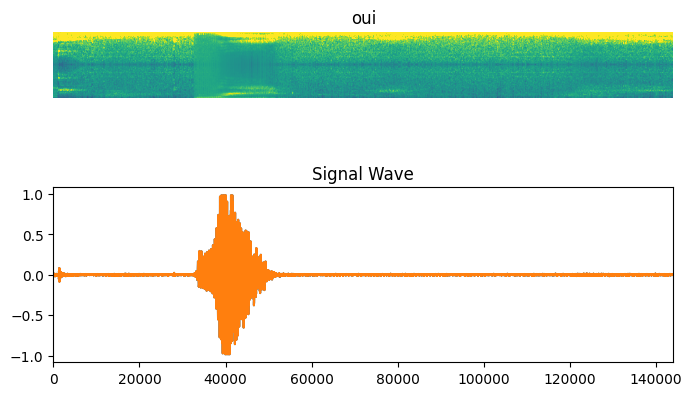

In [13]:
fig = plt.figure(figsize=(8, 5))
i=0
for batch in validation_dataset:
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    print(label)
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_val["wav"])[0])
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
    i+=3
    plt.show()

In [14]:
for element in validation_dataset:
  print(element)

(<tf.Tensor: shape=(1, 1799, 193), dtype=float32, numpy=
array([[[ 3.6165957 ,  3.995937  ,  4.6456194 , ..., -0.27323088,
         -0.45191717, -0.464231  ],
        [ 4.8564067 ,  3.6443942 ,  0.80867857, ..., -0.5995244 ,
         -0.7817935 , -0.70982665],
        [ 4.004357  ,  5.32311   ,  4.8628283 , ..., -0.51368654,
         -0.35007903, -0.33304572],
        ...,
        [ 5.8165774 ,  5.6075354 ,  4.6912675 , ..., -0.7623512 ,
         -0.7705129 , -0.7989401 ],
        [ 3.6480775 ,  4.3276234 ,  2.8591259 , ..., -1.039945  ,
         -0.92878586, -0.7834913 ],
        [ 7.292919  ,  6.1975155 ,  3.2388117 , ..., -0.8591376 ,
         -0.8292128 , -0.80220294]]], dtype=float32)>, <tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[15, 21,  9]], dtype=int64)>)


In [15]:
validation_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 193), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [16]:
weights_filepath = 'C://Users//trist//PycharmProjects//Political_debate_summary//Saved_Model_ATT_HACK//model_51_epochs.hdf5'
model.load_weights(weights_filepath)

## prediction part

predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in range (len(predictions)):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 5s 5s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : oui
Prediction: ou
----------------------------------------------------------------------------------------------------
